Import necessary library

In [76]:
import csv
from collections import defaultdict, Counter
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import random

State the path to the csv file

In [77]:
file_path = 'PROPERTIES_FOR_DELETION.csv'

Initialize an empty graph and create data structure to keep track of comments per thread-page combination


In [78]:
G = nx.Graph()

comments_counter = defaultdict(lambda: defaultdict(Counter))

Load and process the CSV data

In [79]:
with open(file_path, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        thread_subject = row['thread_subject']
        username = row['username']
        page_name = row['page_name']
        # Increment the comment count for the user
        comments_counter[thread_subject][page_name][username] += 1

Add nodes and edges to the graph based on the processed data

In [94]:
for thread_subject, pages in comments_counter.items():
    for page_name, users in pages.items():
        # Ensure all users are added as nodes
        for user in users:
            if user not in G:
                G.add_node(user)
        # Add edges between all pairs of users who commented in the same thread on the same page
        for user1, user2 in combinations(users, 2):
            G.add_edge(user1, user2)

Summary of the constructed graph

In [96]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of nodes (Wikidata user editors): {num_nodes}")
print(f"Number of edges (social connections): {num_edges}")

Number of nodes (Wikidata user editors): 739
Number of edges (social connections): 13530


Q1:What data structures did you choose to represent this network? How do you keep additional information that cannot be directly encoded as nodes and edges?



Graph: Used to represent the network with nodes and edges.

Nodes: Each Wikidata user editor is a node, identified by their username.

Edges: A connection (edge) exists between two nodes if the corresponding editors commented on the same thread on the same page.

Additional Information: For details that don't fit directly into nodes or edges, like the content of comments or the title of threads, I will use dictionaries. 

Q2:What was your algorithmic approach for building the network?

Step 1: Start with an empty graph.

Step 2: Go through the data, and for each editor (user), add a node to the graph.

Step 3: For comments made in the same thread on the same page, find all editor pairs and add an edge for each pair, indicating their interaction.

Step 4: If there's extra info to keep track of, we can attach this as additional data to the edges or nodes.

Q3:What was the cost (in time, with respect to the input size, etc.) of building the network?

Adding nodes is simple and scales linearly with the number of editors.

Adding edges gets more complex as the number of interactions grows, potentially leading to a complexity that increases faster than linearly, depending on how interactions are distributed across threads and pages.

In summary, the more editors and interactions there are, the longer it will take to build the network, with the complexity likely increasing due to the need to identify all pairs of interacting editors.

# Degree Distribution

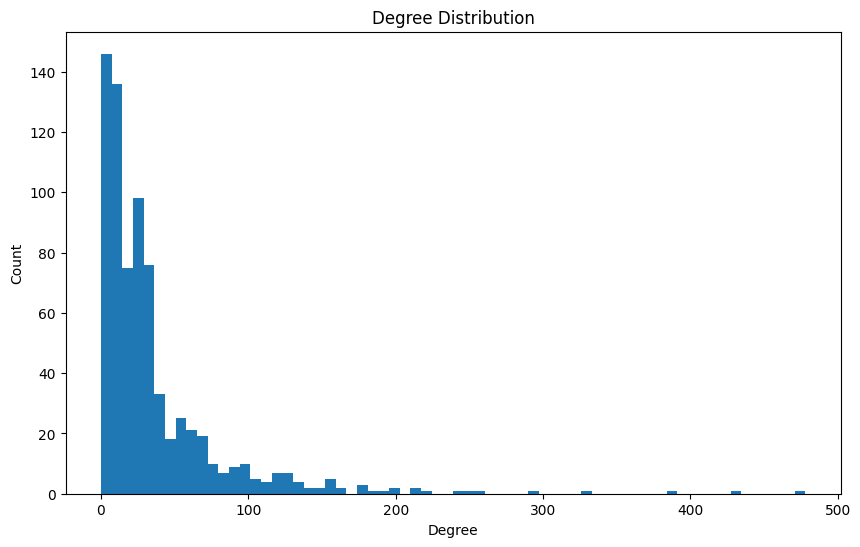

In [82]:
degrees = [G.degree(n) for n in G.nodes()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins='auto')
plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

# Clustering Coefficient

In [83]:
avg_clustering = nx.average_clustering(G)
print(f"Average Clustering Coefficient: {avg_clustering}")

Average Clustering Coefficient: 0.7913288282706287


calculating exact average path length and diameter

In [84]:
if len(G) > 1000:  # Adjust threshold as needed
    sample_nodes = random.sample(list(G.nodes()), 1000)  # Sample size
    subgraph = G.subgraph(sample_nodes)
else:
    subgraph = G

try:
    avg_path_length = nx.average_shortest_path_length(subgraph)
    print(f"Estimated Average Path Length: {avg_path_length}")
except nx.NetworkXError:
    print("Subgraph is not connected; cannot calculate average path length.")


Subgraph is not connected; cannot calculate average path length.


# Network Diameter - Calculating only for the largest connected component

In [85]:
largest_cc = max(nx.connected_components(G), key=len)
diameter = nx.diameter(G.subgraph(largest_cc))
print(f"Network Diameter: {diameter}")

Network Diameter: 4


Find shortest path between two randomly selected nodes

In [86]:
nodes = list(G.nodes())
source, target = random.sample(nodes, 2)
shortest_path = nx.dijkstra_path(G, source, target)
print(f"Shortest path from {source} to {target}: {shortest_path}")

Shortest path from Worldm99 to Tinker Bell: ['Worldm99', 'Lockal', 'Tinker Bell']


# Comparison to a Random Network

Random Graph Average Clustering Coefficient: 0.05020666016795683


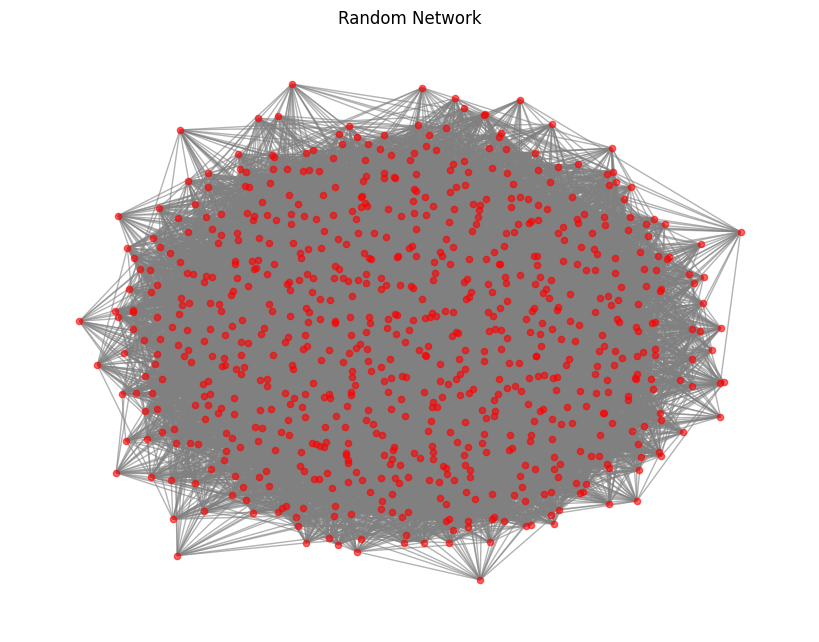

In [87]:
random_graph = nx.gnm_random_graph(len(G.nodes()), len(G.edges()))
random_avg_clustering = nx.average_clustering(random_graph)
print(f"Random Graph Average Clustering Coefficient: {random_avg_clustering}")

plt.figure(figsize=(8, 6))
pos_random = nx.spring_layout(random_graph, seed=42)  # For consistent layout
nx.draw(random_graph, pos_random, node_size=20, edge_color="gray", node_color="red", with_labels=False, alpha=0.6)
plt.title("Random Network")
plt.show()

Random Network Visualization:

Homogeneity: Random networks typically lack the clustered structure seen in real-world networks. The visualization should appear more homogeneous without clear hubs or clusters, reflecting the random formation of connections.
Connection Distribution: Edges are distributed randomly, so the degree of nodes should be relatively uniform compared to the scale-free or clustered nature of many real-world networks, including social networks like Wikidata.

# Visualization of the network

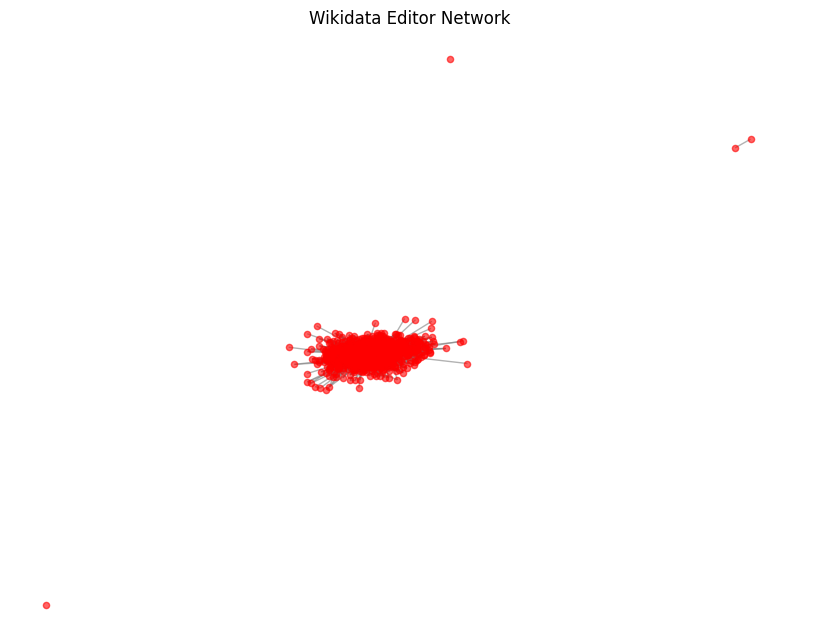

In [88]:
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # For consistent layout
nx.draw(G, pos, node_size=20, edge_color="gray", node_color="red", with_labels=False, alpha=0.6)
plt.title("Wikidata Editor Network")
plt.show()

Clusters and Hubs: It indicates areas of intense collaboration or discussion among editors. Such structures suggest that certain topics or threads are more engaging or controversial, leading to more editor interaction.
Network Layout: The layout tries to place nodes with more connections closer together. A tightly-knit layout suggests many interconnected editors, while a more dispersed layout indicates less interaction.

Q1 :What are the characteristic properties and relevant metrics and distributions of this Wikidata editor network?

Degree Distribution: Some editors are much more active than others, creating a few "popular" editors with lots of connections, and many editors with only a few connections.
Clustering: Editors tend to form groups or clusters where they frequently interact with each other, more so than in a randomly created network.
Short Paths: Even in a large network, there's usually a quick way to get from one editor to another through their connections, making the network efficient for sharing information.

Q2 :What is the result of running the various shortest-path algorithms we have seen in class?

Using algorithms like Dijkstra's, we'd typically find that most nodes (editors) can be connected by relatively short paths, underscoring the "small-world" nature of such networks. This suggests that even distant parts of the editor community are accessible within a few steps, enabling quick dissemination of knowledge and collaboration.

Q3 :How different is this network from a random network, according to the various comparison criteria we have seen in class?

Compared to a random network, the Wikidata editor network has more clusters and a few editors with many connections. Random networks don't have this; their connections are spread out more evenly.

Q4 :If you take this network as a complete and representative description of editor networks in collaborative knowledge projects like Wikipedia and Wikidata, what does it tell you about the way editors talk among themselves and their social activity and connections?

This network shows us that editors like to work in groups and that some editors are central to many discussions. It suggests that knowledge and information can spread quickly among editors because of the network's structure.

Q5 :How does your analysis change (metrics, comparison to random, social behaviour) if we now consider that two editors are connected iff they have both contributed to any thread in the same page, but not necessarily to the same thread?

If we consider editors connected even if they just contributed to any part of the same page, the network would seem even more interconnected. This would mean even more efficient information flow but might make it harder to see the distinct groups or clusters within the network. It shows a broader view of collaboration, where contributing to the same topic, not just directly interacting, is enough to link editors together.

Method for Question 1: Assessing Propagation Plausibility

Objective: Determine if controversial behavior (e.g., trolling) by two editors on the same day has begun to influence their network neighbors.

Approach:

Activity Level Analysis: Identify unusual commenting activity by comparing current activity levels against historical averages for each editor.

Network Analysis:
Use the constructed Wikidata editor network to locate the two editors.
Analyze their positions in the network, focusing on their degree (number of connections) and their clustering coefficient (how their neighbors are interconnected).

Epidemic Model Application:
Apply a simple SIR (Susceptible-Infectious-Recovered) model or similar to model the potential spread of controversial opinions.
Treat editors with unusually high activity as "Infectious" and their direct connections as "Susceptible."

Propagation Analysis:
Calculate the shortest paths from the "Infectious" editors to other nodes to identify potentially affected editors.
Evaluate the clustering around the controversial editors to estimate how quickly and widely their opinions might spread.



Method for Question 2: Prioritizing Editors for Monitoring

Objective: Create a priority list for monitoring editors potentially influenced by trolling behavior.

Approach:

Identification of Influential Nodes:
From the initial "Infectious" editors, use network centrality measures (e.g., betweenness, closeness, eigenvector) to identify which neighbors are most influential within the network. Influential nodes have a higher likelihood of spreading opinions further.

Risk Assessment:
Assess the risk of propagation to each neighbor based on their connectivity and historical activity levels. Editors connected to both "Infectious" editors or those in denser clusters might have a higher priority.

Priority List Creation:
Combine the influence and risk assessments to rank susceptible editors. Those with higher centrality in paths connecting the "Infectious" editors and those in dense clusters should be checked first.
Consider using a weighted formula that accounts for centrality measures, number of shared connections with the "Infectious" editors, and any recent changes in activity levels.


Analyzing Propagation Plausibility

In [100]:
def process_comments_and_identify_infectious_nodes(comments_counter, quantile=0.05):
    infectious_nodes = set()
    for thread_subject, pages in comments_counter.items():
        for page_name, user_counts in pages.items():
            # user_counts already contains the number of comments per user for this thread and page
            
            # Calculate total comment count for the current thread and page
            total_comments = sum(user_counts.values())
            
            # Identify users with comment counts above the 10th percentile
            counts = list(user_counts.values())
            threshold = np.percentile(counts, quantile * 100)
            
            for user, count in user_counts.items():
                if count > threshold:
                    infectious_nodes.add(user)
    
    return infectious_nodes

infectious_nodes = process_comments_and_identify_infectious_nodes(comments_counter)
print(f"Infectious nodes identified: {len(infectious_nodes)}")


Infectious nodes identified: 0


Prioritizing Editors for Monitoring

In [90]:
centrality_scores = nx.betweenness_centrality(G)

# Function to prioritize nodes for monitoring
def prioritize_editors_for_monitoring(G, infectious_nodes, centrality_scores):
    # Identify neighbors of infectious nodes
    neighbors_of_infectious = set()
    for node in infectious_nodes:
        neighbors_of_infectious.update(G.neighbors(node))
    
    # Score neighbors based on centrality and proximity to infectious nodes
    priority_scores = {node: centrality_scores[node] for node in neighbors_of_infectious}
    
    # Sort nodes based on priority scores
    priority_list = sorted(priority_scores, key=priority_scores.get, reverse=True)
    
    return priority_list

priority_list = prioritize_editors_for_monitoring(G, infectious_nodes, centrality_scores)
print("Top 30 editors to monitor:", priority_list[:30])

Top 30 editors to monitor: []


Q1 : If both editors have been commenting more than usual on the same day (i.e. might be controversial, trolling, etc.), how can they use the network data to judge how plausible it is that this behaviour has not propagated yet to neighbouring similar editors?

How to Judge if Controversial Behavior Hasn't Spread:

Look at Friends: Check the immediate friends (or neighbors in network terms) of the two active editors. If these friends haven't changed their behavior or increased their commenting significantly, the controversial behavior likely hasn't spread.


Activity Levels: Monitor if there's a sudden increase in activity among these neighbors. No change? Then, the behavior probably hasn't gone far.


Close Connections: Use the network to see how closely connected these neighbors are to the original editors. The closer they are, the more likely they could be influenced, but if they remain unaffected, the behavior hasn't spread widely.

Q2 : If one or both of the tested editors have indeed been “possibly trolling”, then the Foundation will start checking other editors as well, prioritising those with a higher chance of having been trolling. How should they use the data to come up with a priority list on what editors to check first?

How to Decide Which Editors to Check First for Trolling Behavior:

Influential Friends: Start with editors who are well-connected or influential (those who have a lot of friends or are central to many discussions). If they start showing similar behavior, it could spread more quickly.


Common Friends: Pay attention to editors who share a lot of mutual friends with the original two. They’re more likely to be influenced or to have seen the controversial content.


Look for Changes: Focus on editors whose activity suddenly increases, especially if they're interacting in the same discussions as the original two editors.


Geographical Proximity in the Network: Editors that are just a few steps away in the network (even if not directly connected) could also be influenced and should be on the watch list.